<a href="https://colab.research.google.com/github/mini-u/BasicDL/blob/main/%5B2023_12_06_%EC%98%A4%ED%9B%84_4_22_46%5D_0_%EC%9C%A0%EC%84%B1%EB%AF%BC_%EC%8B%A4%EC%8A%B5%EB%A6%AC%ED%8F%AC%ED%8A%B812.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **실습리포트12**



*   이름: 유성민
*   학과: 생명환경공학전공
*   학번: 2019110881

In [ ]:
import tensorflow as tf
import numpy as np
import keras
from keras import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

# **시계열 분석**

- 문제: 시물레이션 시계열 데이터로 분석하기, 무작위로 만든 데이터를 시계열 분석해서 예측하기

- 결과: 어제와 오늘이 무조건 같다고 예측하는 Naive 방식의 경우 평균절대오차가 5.75 정도로 나왔다. 노드가 1개인 선형회귀 모델로 예측한 경우 4.89로 성능이 향상된 것을 확인할 수 있었다. 마지막으로 은닉층이 2개인 신경망 모델의 경우에는 4.76으로 성능이 조금 더 개선 된 것을 확인할 수 있었다.

In [ ]:
#데이터 만들기

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4, np.cos(season_time * 2*np.pi),
                  1/np.exp(3*season_time))

time = np.arange(4*365, dtype="float32")
baseline=0
trend=0.05*time
seasonality=40* seasonal_pattern((time%365)/365)
noise=5 * np.random.RandomState(127).randn(len(time))

series=baseline + trend+seasonality +noise

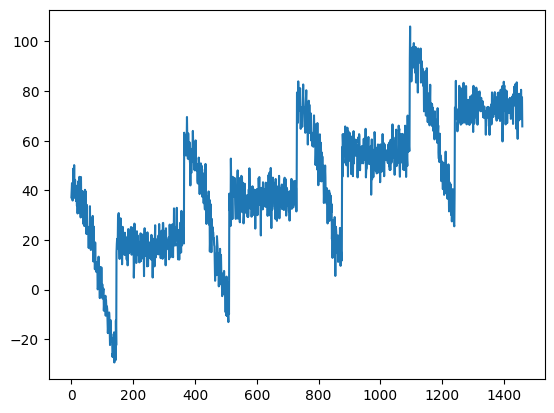

In [ ]:
plt.plot(series)
plt.show()

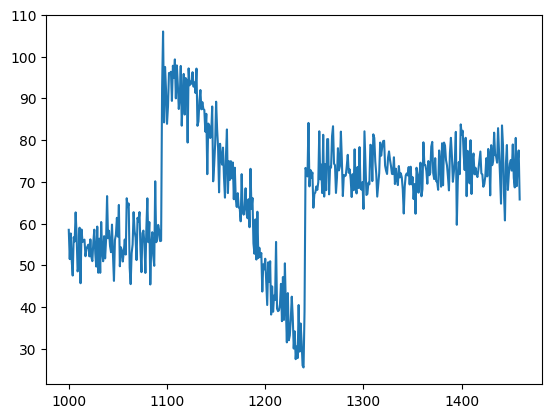

In [ ]:
#validation data

time_train =time[:1000]
x_train=series[:1000]
time_valid=time[1000:]
x_valid=series[1000:]

plt.plot(time_valid, x_valid)
plt.show()

In [ ]:
#naive 예측 방법

forecast=series[1000-1:-1]
error=forecast-x_valid
mae=np.abs(error).mean()
print(mae)

5.747959837758882


In [ ]:
#윈도우 데이터 생성함수

def win_ds(series, window_sie, batch_size, shuffle_buffer):
  ds=tf.data.Dataset.from_tensor_slices(series)
  ds=ds.window(window_size+1, shift=1, drop_remainder=True)
  ds=ds.flat_map(lambda win: win.batch(window_size+1))
  ds=ds.map(lambda win: (win[:-1], win[-1]))
  ds=ds.shuffle(shuffle_buffer)
  ds=ds.batch(batch_size).prefetch(1)
  return ds

In [ ]:
window_size=20
batch_size=32
shuffle_buffer_size=1000

dataset=win_ds(x_train, window_size, batch_size, shuffle_buffer_size)

### **노드가 1개인 선형 회귀 모델**

In [ ]:
#모델 정의 = 노드가 1개인 선형 회귀 모델

model=Sequential([
    Dense(1, input_shape=[window_size])
])

In [ ]:
#모델 컴파일

SGD=keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss='mse', optimizer=SGD)

In [ ]:
#모델 훈련

history=model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 1311.2697
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 165.1142
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 112.8471
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 101.9081
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 96.2398
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 91.5775
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 88.5846
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 85.9955
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 84.1373
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 82.8830
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 80.7608
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 79.4395
Epoch 13/100
31/31 [

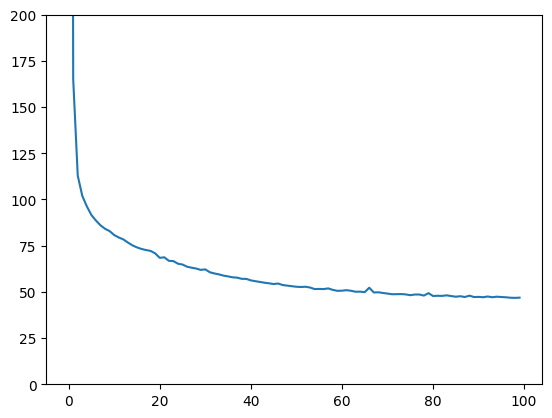

In [ ]:
#모델 평가 - traning loss

loss=history.history['loss']
plt.plot(loss)
plt.ylim(0,200)
plt.show()

In [ ]:
#모델평가 - prediction

forecast=[]
for time in range(len(series) -window_size):
  pred = model.predict(series[time:time+window_size][np.newaxis])
  forecast.append(pred)

forecast= forecast[1000-window_size:]
results=np.array(forecast)[:, 0, 0]

1/1 [==============================] - 0s 19ms/step


In [ ]:
#모델 평가 - mae

keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.8902054

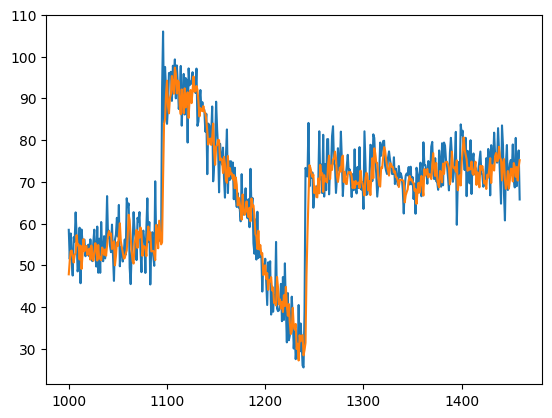

In [ ]:
#성능향상 확인

plt.plot(time_valid, x_valid)
plt.plot(time_valid, results)
plt.show()

### **은닉층이 2개인 모델**

In [ ]:
#모델 정의 =은닉층이 2개인 모델

model2 = Sequential ([
    Dense(10, input_shape=[window_size], activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
 ])

In [ ]:
#모델 컴파일

SGD=keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model2.compile(loss='mse', optimizer=SGD)

In [ ]:
#모델 훈련

history2=model2.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 136.4721
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 120.1185
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 110.6963
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 102.7215
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 97.0994
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 92.6648
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 88.9237
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 86.1084
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 83.9773
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 81.3815
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 79.6384
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 77.6457
Epoch 13/100
31/31 [=

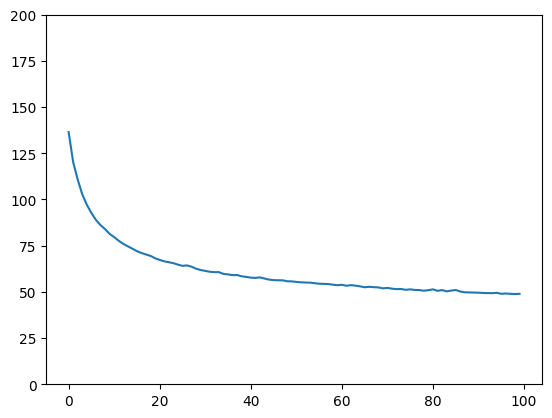

In [ ]:
#모델 평가 training loss

loss=history2.history['loss']
plt.plot(loss)
plt.ylim(0,200)
plt.show()

In [ ]:
#모델평가 - prediction

forecast2=[]
for time in range(len(series) -window_size):
  pred2 = model2.predict(series[time:time+window_size][np.newaxis])
  forecast2.append(pred2)

forecast2= forecast2[1000-window_size:]
results2=np.array(forecast2)[:, 0, 0]

1/1 [==============================] - 0s 16ms/step


In [ ]:
#모델 평가 - mae

keras.metrics.mean_absolute_error(x_valid, results2).numpy()

4.767741

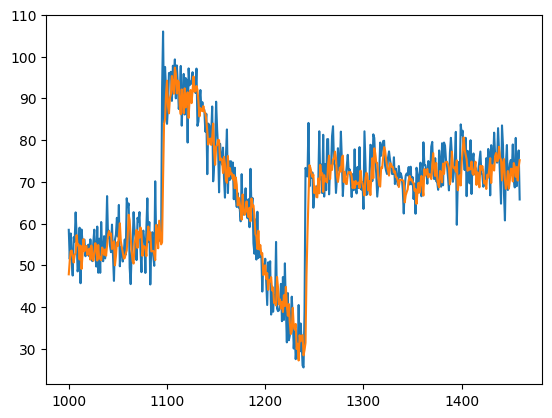

In [ ]:
#성능향상 확인

plt.plot(time_valid, x_valid)
plt.plot(time_valid, results)
plt.show()